In [ ]:
from zero_shot_time.data.splits import create_train_test_split, get_custom_train_test_split
from zero_shot_time.data import get_dataset
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import seaborn
import pickle

In [ ]:
def compute_maes(data, test_sets, scaler = 1):
    mea = 0
    last_meas =  0
    for i in range(len(test_sets)):
        slc = pd.concat(data[(i)*20:(i+1)*20]).groupby(['x']).median()['y']
        pred = slc[-len(test_sets[i]):]
        mea += np.mean(np.abs(pred - test_sets[i]))
        last_meas += np.abs(pred - test_sets[i]).array[-1]
    return mea / len(test_sets), mea / len(test_sets) / scaler


In [24]:





def plot_dataset_forecasts(configs, models, limit=5):
    res = []
    for dataset_name, (dataset_origin , scaler) in configs.items():
        dataset, target = get_dataset(dataset_name=dataset_origin, sub_category=dataset_name)
        if target is not None:
            # Create train, validation, test split
            _, train_sets, test_sets = create_train_test_split(dataset["train"], dataset["test"], target=target)
        else:
            _, train_sets, test_sets = get_custom_train_test_split(dataset, split_fraction=0.2)
        for model_name in models:
            data = []
            with open(f'./{dataset_origin}_{dataset_name}_{model_name}.data.pickle', 'rb') as f:
                preds = pickle.load(f)
                f.close()
            for p_idx, p in enumerate(preds):
                for r_index, r in enumerate(p[0][0]):
                    data.append(
                            pd.DataFrame(
                                    data={
                                        'x': np.arange(len(r)).flatten().tolist(),
                                        'y': r,
                                        'v': [p_idx] * len(r),
                                        'r': [r_index] * len(r)
                                    }
                            )
                    )
            assert len(data) == 20 * len(train_sets)
            mae, maes =  compute_maes(data, test_sets, scaler)
            print(dataset_name, model_name, mae, maes)
            res += [{'dataset': dataset_name,
                     'model': model_name,
                     'mae': mae,
                     'maes': maes}
                    ]
            for i in range(min(limit, len(test_sets))):
                # Getting the 20 predictions
                slc = pd.concat(data[(i)*20:(i+1)*20])
                train_len = len(train_sets[i])
                pred_len = len(test_sets[i])
                # Plotting prediction, taking additional steps to 'connect' the lines
                # Note that we plot the median!
                seaborn.lineplot(slc[slc.x > train_len-2], x='x', y='y', errorbar='ci',
                             estimator=np.median, color='blue')
                # Plot historical data
                plt.plot(np.arange(len(train_sets[i])), train_sets[i], color='black')
                # Plot slightly transparent future data
                plt.plot(np.arange(len(train_sets[i])-1, len(train_sets[i]) + pred_len), [train_sets[i][-1]] + test_sets[i], linewidth=2, alpha=0.7, color='orange')

                # Set title of figure
                plt.title(f'{dataset_name} {model_name} series: {i+1}')
                plt.savefig(f'./plots/{dataset_name}_{model_name}_{i+1}.pdf')

                # Show figure after saving it
                plt.show()
    return res


## Plotting Darts results

Then we consider the Darts result, plotting them with our defined function. We also write the plots to the [`./plots/`](./plots) directory.

Additionally, we create a table that allows us to view the results in a single overview for the blog post!

airpassenger gpt2 73.28303571428572 73.28303571428572


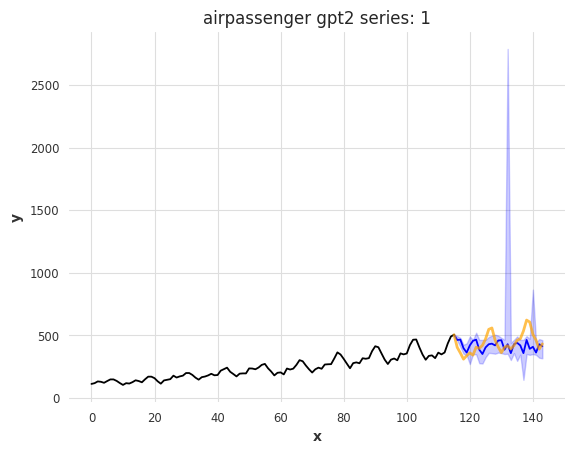

airpassenger gpt2-large 220.15133035714283 220.15133035714283


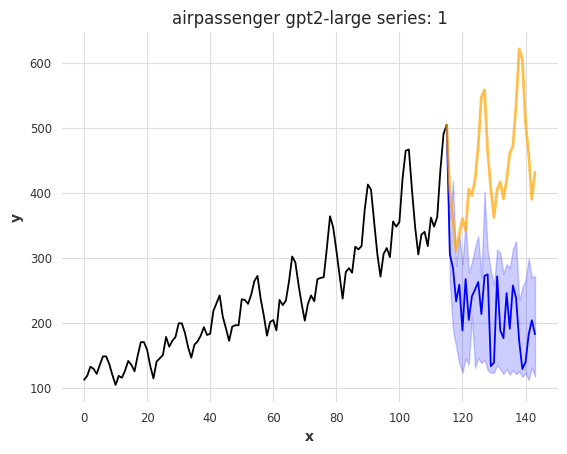

airpassenger Llama-2-7b-hf 112.78121785714278 112.78121785714278


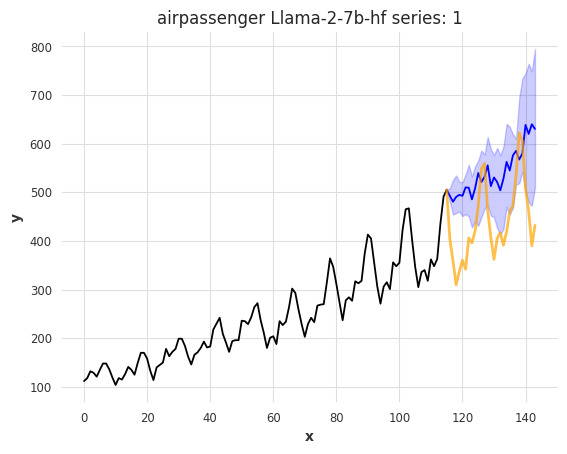

airpassenger Llama-2-13b-hf 70.65298392857139 70.65298392857139


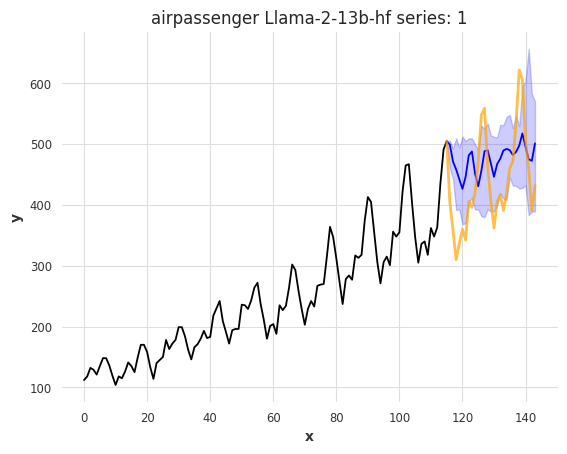

beer gpt2 51.82326190476192 51.82326190476192


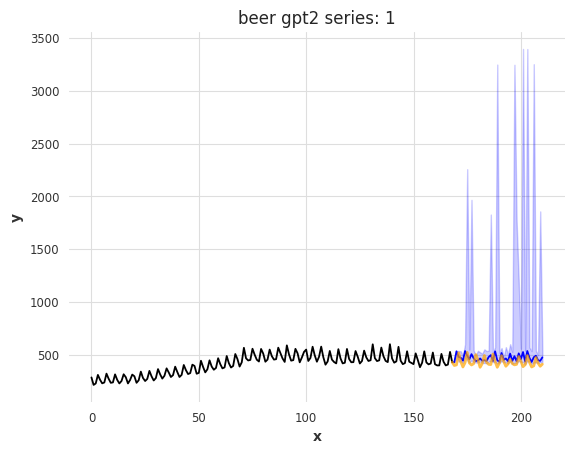

beer gpt2-large 187.08904761904765 187.08904761904765


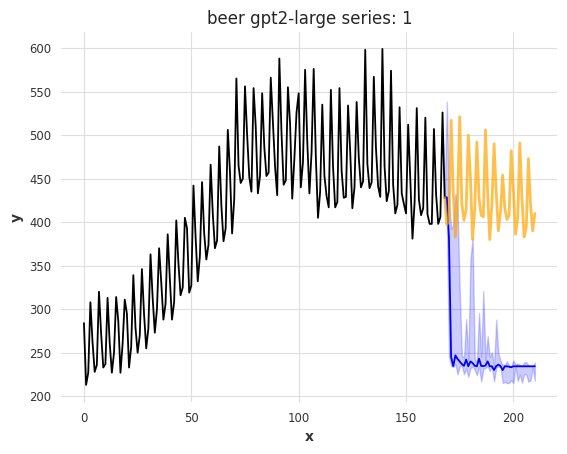

beer Llama-2-7b-hf 29.564690476190474 29.564690476190474


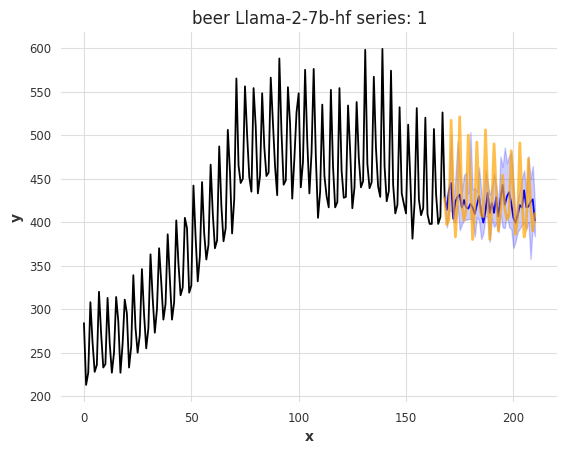

beer Llama-2-13b-hf 28.85971428571429 28.85971428571429


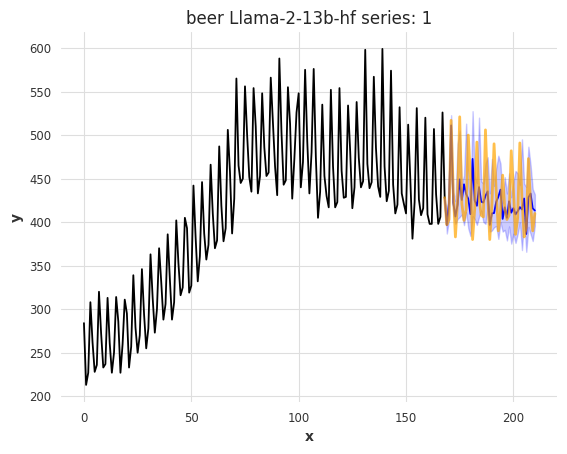

\begin{tabular}{llr}
\toprule
model & dataset & mae \\
\midrule
gpt2 & airpassenger & 73.283036 \\
gpt2-large & airpassenger & 220.151330 \\
Llama-2-7b-hf & airpassenger & 112.781218 \\
Llama-2-13b-hf & airpassenger & 70.652984 \\
gpt2 & beer & 51.823262 \\
gpt2-large & beer & 187.089048 \\
Llama-2-7b-hf & beer & 29.564690 \\
Llama-2-13b-hf & beer & 28.859714 \\
\bottomrule
\end{tabular}



In [26]:
# Scaler take from original repository
darts_models = ['gpt2', 'gpt2-large', 'Llama-2-7b-hf', 'Llama-2-13b-hf']
darts_dataset = {
    'airpassenger': ('darts', 1.0),
    'beer': ('darts', 1.0),
}

darts_result = plot_dataset_forecasts(darts_dataset, darts_models, limit=1)

print(pd.DataFrame(darts_result)[['model', 'dataset', 'mae']].to_latex(index=False))

## Plotting Monash results

tourism_yearly gpt2 191399.7271308391 1.9244653223886854


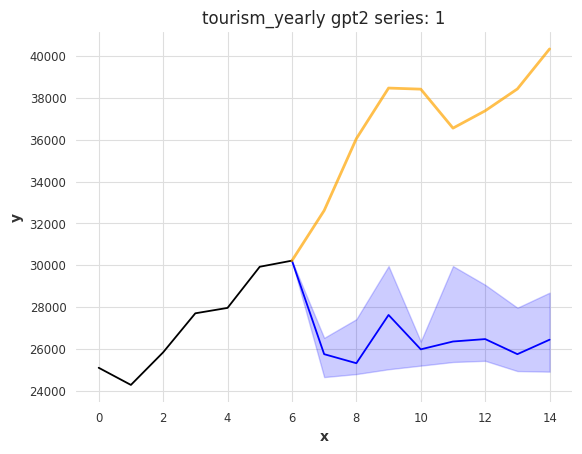

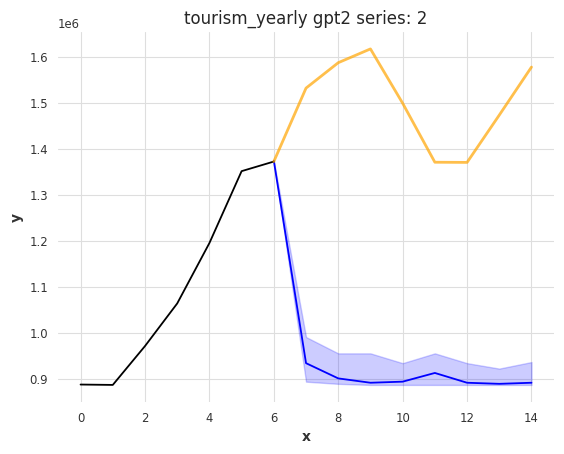

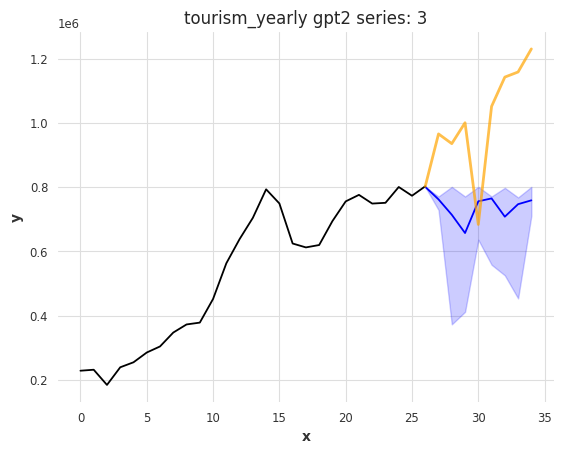

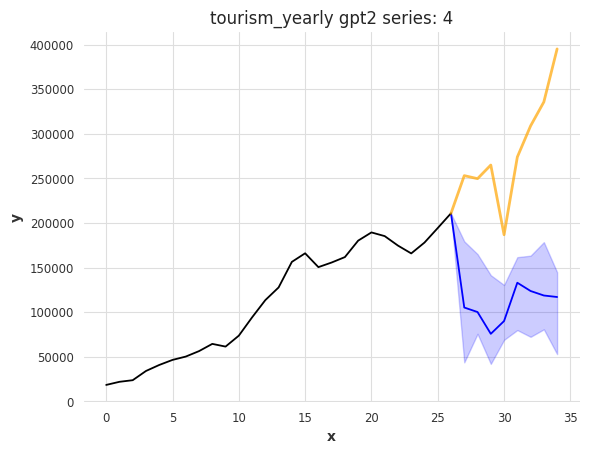

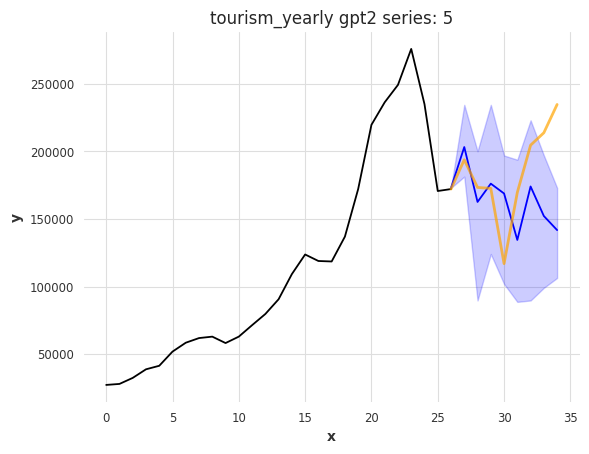

tourism_yearly gpt2-large 214060.60485532923 2.1523134703949784


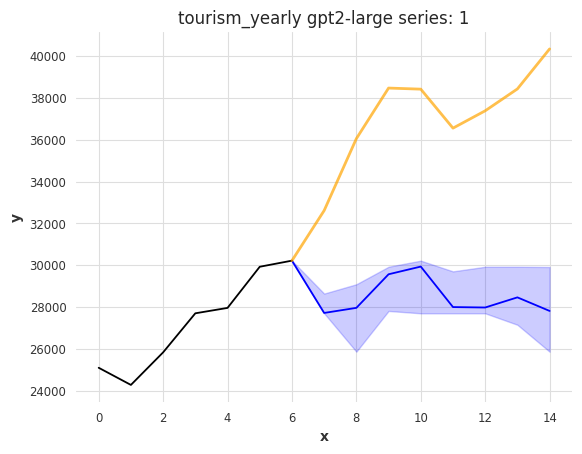

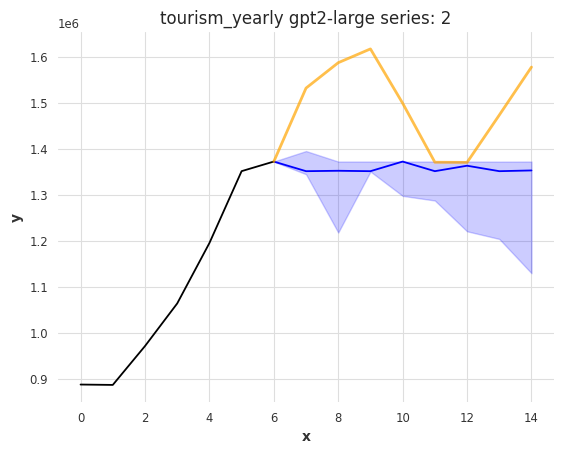

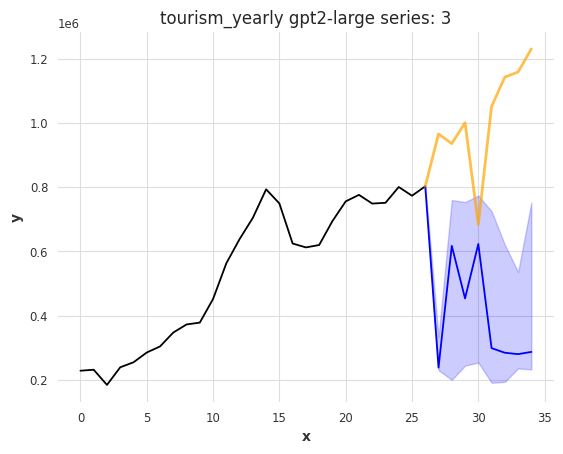

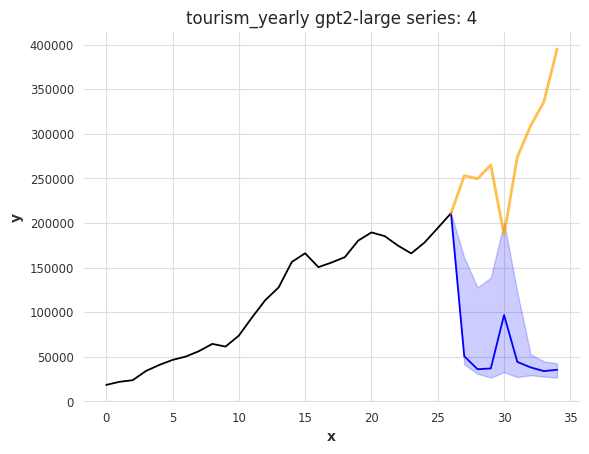

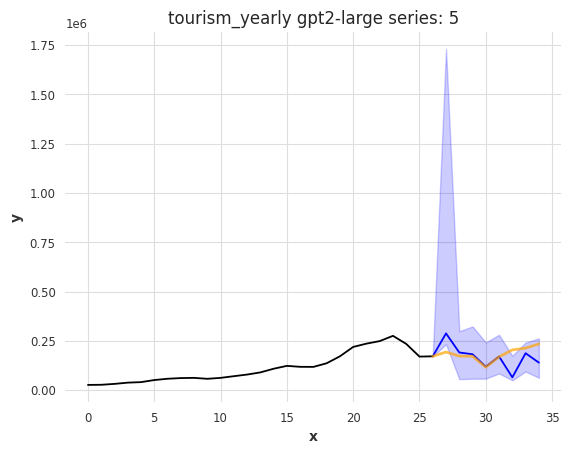

tourism_yearly Llama-2-7b-hf 82840.69082199274 0.8329376387285383


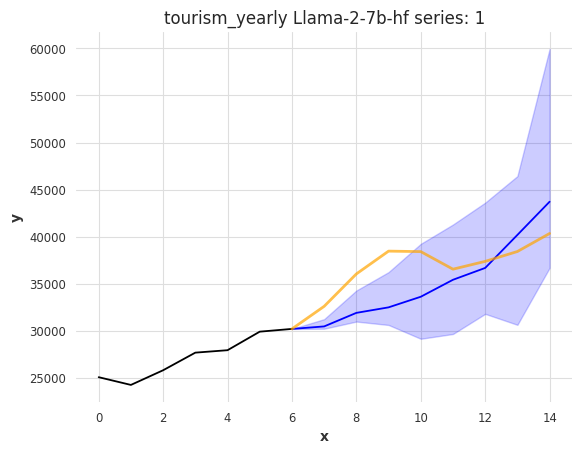

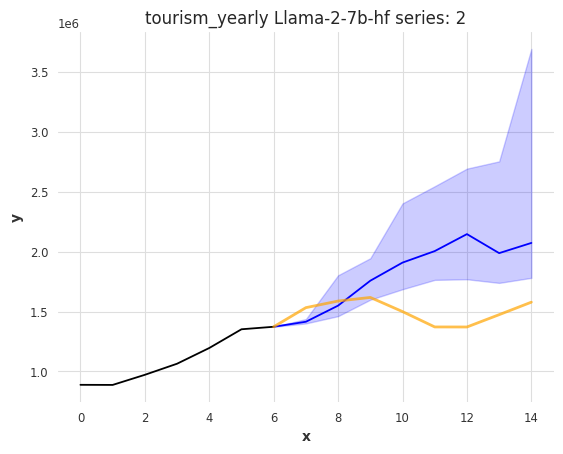

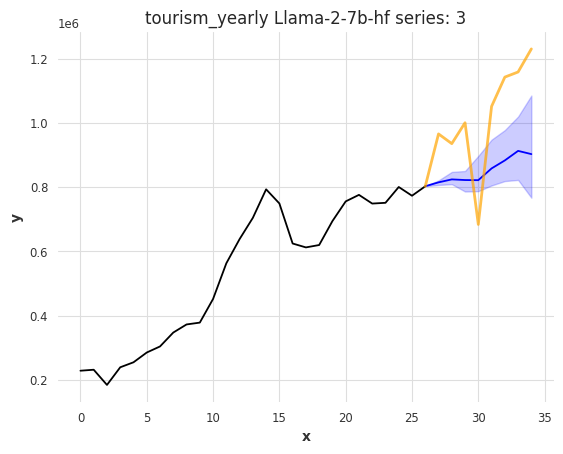

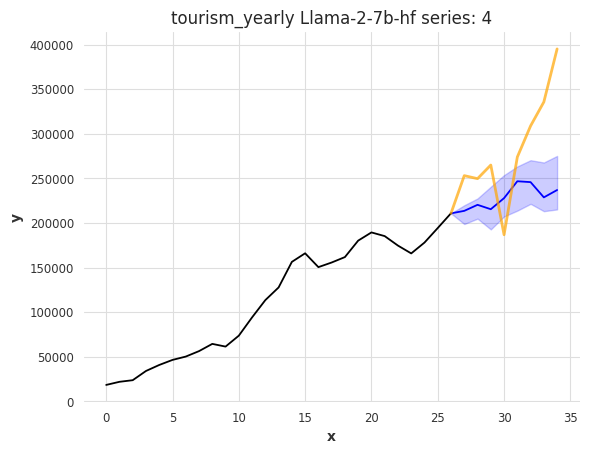

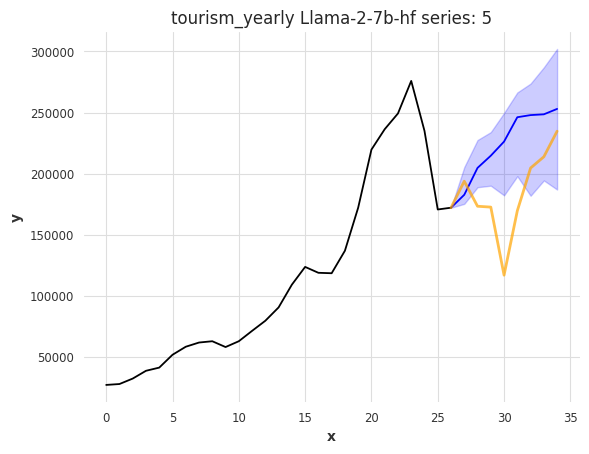

nn5_weekly gpt2 52.84072563777353 3.162495519843547


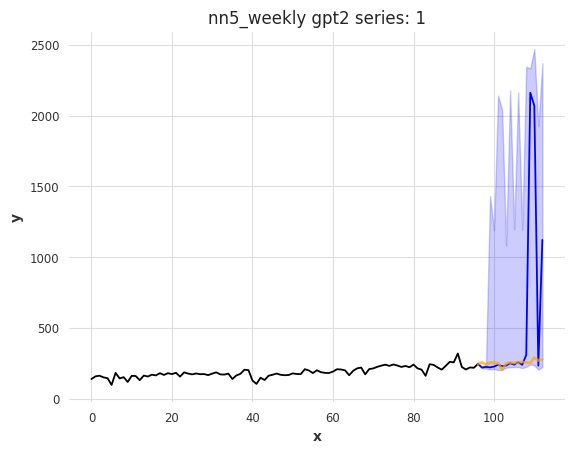

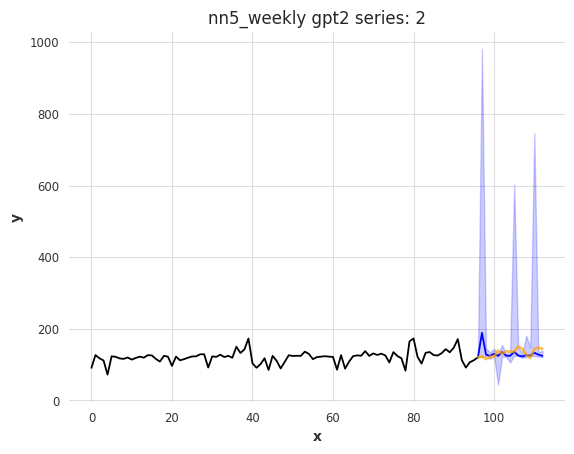

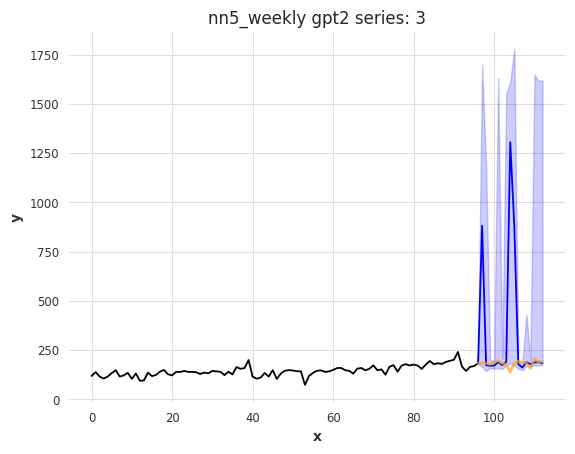

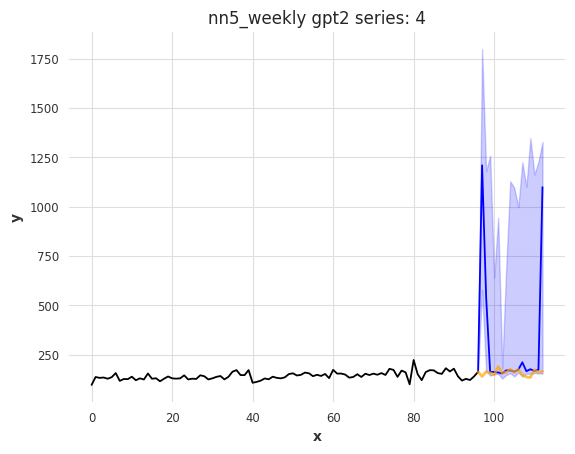

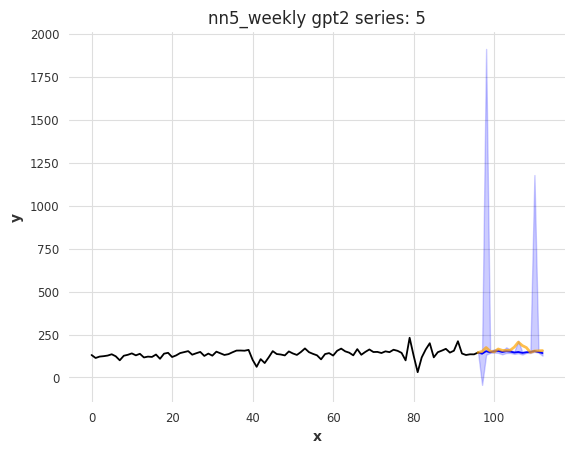

nn5_weekly gpt2-large 36.6711093256038 2.194750688037703


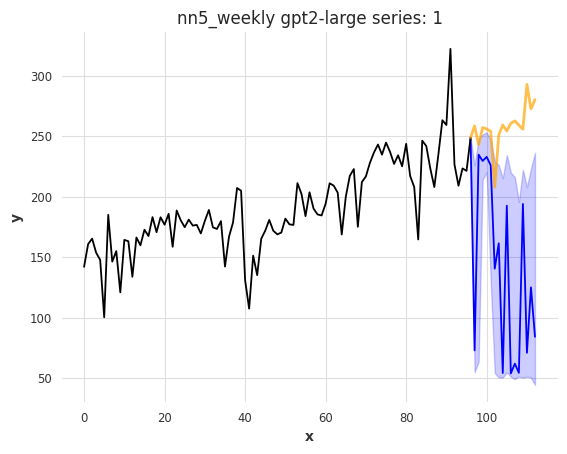

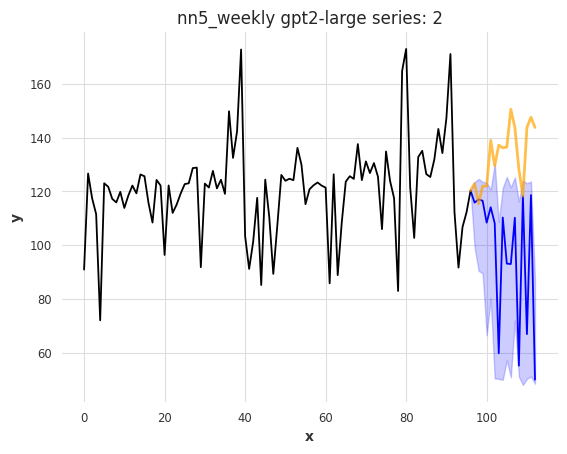

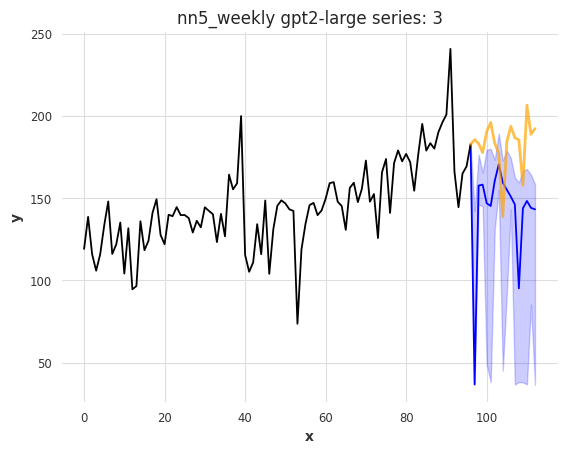

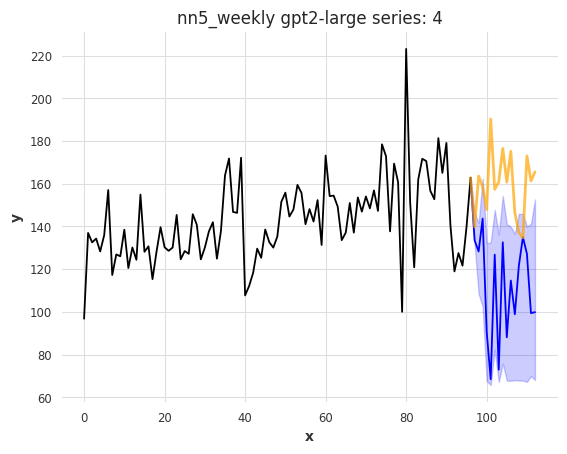

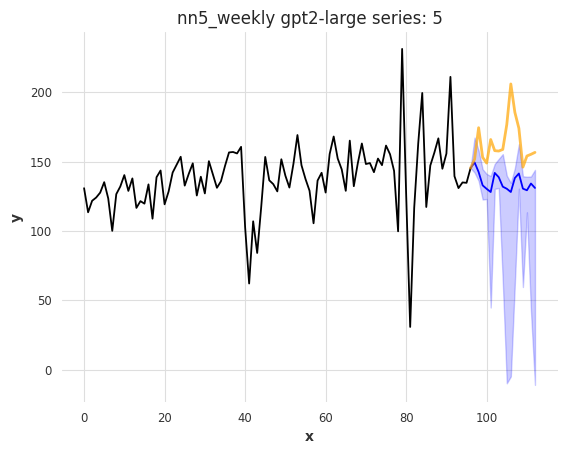

nn5_weekly Llama-2-7b-hf 15.948689455779348 0.954522451054732


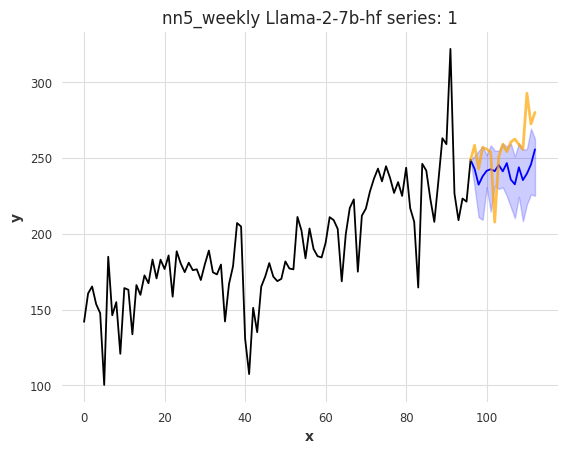

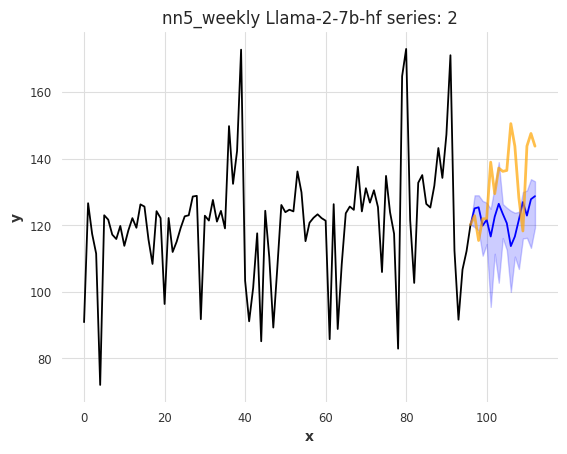

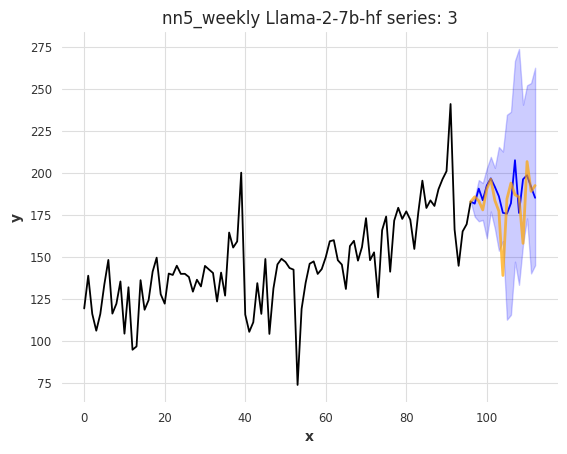

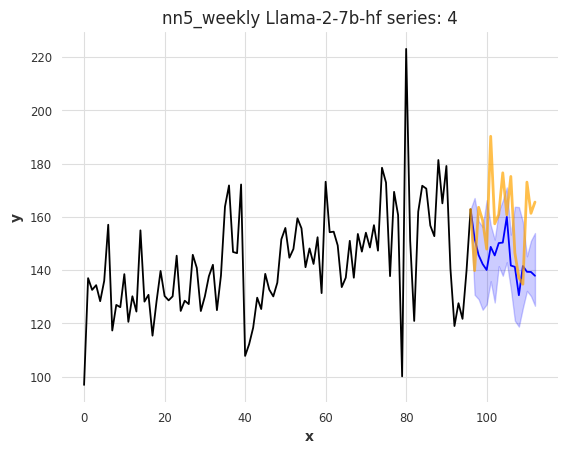

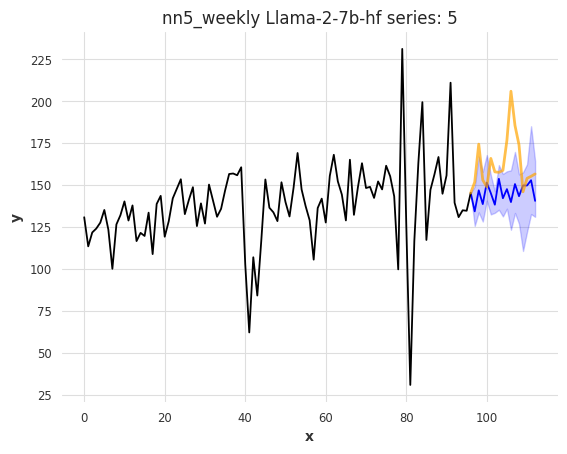

\begin{tabular}{llrr}
\toprule
 &  & mae & maes \\
model & dataset &  &  \\
\midrule
gpt2 & tourism_yearly & 191399.727131 & 1.924465 \\
\cline{1-4}
gpt2-large & tourism_yearly & 214060.604855 & 2.152313 \\
\cline{1-4}
Llama-2-7b-hf & tourism_yearly & 82840.690822 & 0.832938 \\
\cline{1-4}
gpt2 & nn5_weekly & 52.840726 & 3.162496 \\
\cline{1-4}
gpt2-large & nn5_weekly & 36.671109 & 2.194751 \\
\cline{1-4}
Llama-2-7b-hf & nn5_weekly & 15.948689 & 0.954522 \\
\cline{1-4}
\bottomrule
\end{tabular}



In [25]:
# Scaler take from original repository
monash_models = ['gpt2', 'gpt2-large', 'Llama-2-7b-hf']

monash_datasets = {
    'tourism_yearly': ('monash_tsf', 99456.0540551959), # https://github.com/ngruver/llmtime/blob/a9b451b9dad4b443d5c00652b39d922effd8870e/data/last_val_mae.csv?plain=1#L13
    'nn5_weekly':('monash_tsf', 16.708553516113007), # https://github.com/ngruver/llmtime/blob/a9b451b9dad4b443d5c00652b39d922effd8870e/data/last_val_mae.csv?plain=1#L21
}

darts_result = plot_dataset_forecasts(monash_datasets, monash_models, limit=5)

print(pd.DataFrame(darts_result)[['model', 'dataset', 'mae', 'maes']].pivot( index=[ 'model', 'dataset'], columns=[]).to_latex())